In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
import pandas as pd
from pandas import read_csv
#load Data
dataset = read_csv("C:/Users/Gandy Family/Documents/Models/Economic Model.csv", header=0, index_col=0,  encoding = 'unicode_escape')
dataset.columns = ['Delinquency','CPI','GDP','PAY','PPI','HOUSE','UNEM','TRADE']
dataset.index.name = 'Date'
#Summarize First 5 rows
print(dataset.head(5))
print(dataset.shape)

           Delinquency  CPI  GDP  PAY  PPI  HOUSE  UNEM  TRADE
Date                                                          
1/1/1987          6.75  1.2  3.0  0.6  1.3    2.9  -3.4    0.5
4/1/1987          6.75  1.1  4.4  0.8  1.7   -8.5  -5.1    1.0
7/1/1987          6.40  1.1  3.5  0.7  1.9    0.8  -4.3    1.2
10/1/1987         6.23  0.9  7.0  0.9  2.4   -6.2  -2.8    0.6
1/1/1988          5.85  0.8  2.1  0.7  0.9   -6.5  -2.3    1.5
(132, 8)


In [3]:
#Time Series Visualization

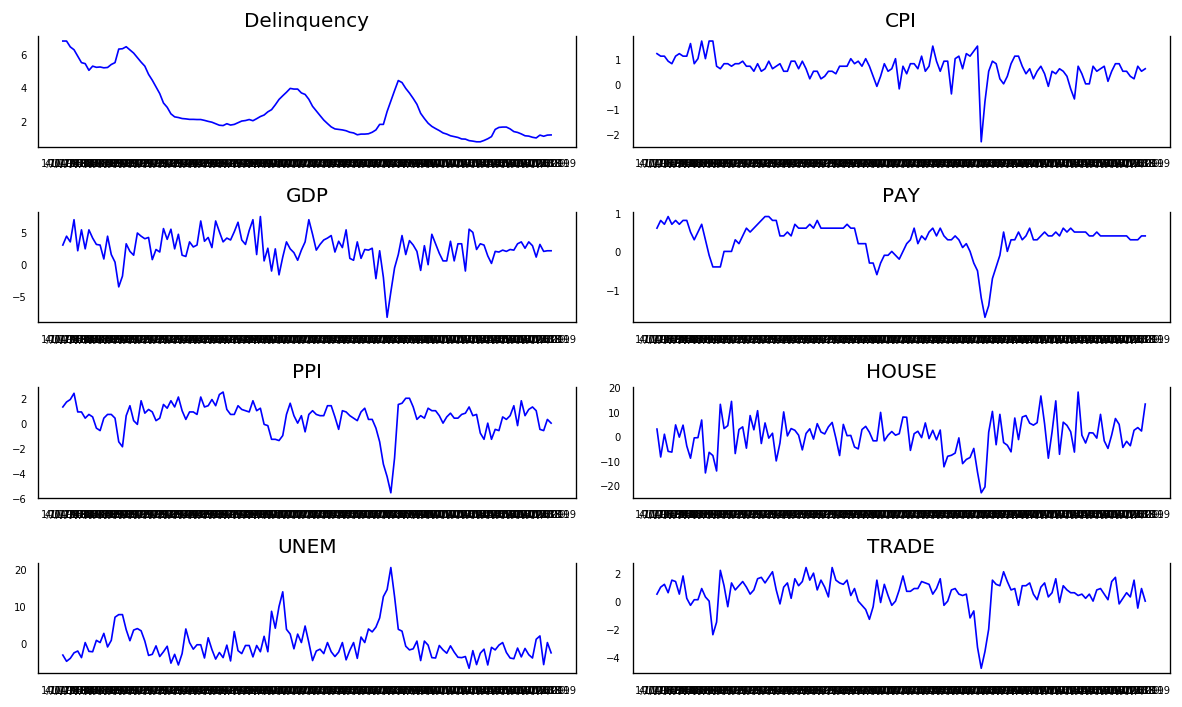

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
# Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [5]:
#Testing Causation using Granger’s Causality Test

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    dataset_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset_train.columns:
        for r in dataset_train.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_value = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_value)
            dataset_train.loc[r, c] = min_p_value
    dataset_train.columns = [var + '_x' for var in variables]
    dataset_train.index = [var + '_y' for var in variables]
    return dataset_train
grangers_causation_matrix(dataset, variables = dataset.columns)

,Delinquency_x,CPI_x,GDP_x,PAY_x,PPI_x,HOUSE_x,UNEM_x,TRADE_x
Delinquency_y,1.0000,0.0002,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000
CPI_y,0.0005,1.0000,0.0812,0.2040,0.1247,0.3755,0.0450,0.0115
GDP_y,0.2435,0.0008,1.0000,0.0033,0.0001,0.0200,0.0330,0.0000
PAY_y,0.0001,0.0001,0.0002,1.0000,0.0000,0.0000,0.0000,0.0000
PPI_y,0.0078,0.0015,0.0000,0.0603,1.0000,0.0006,0.1922,0.0000
HOUSE_y,0.0116,0.0007,0.0198,0.0221,0.3721,1.0000,0.0079,0.0442
UNEM_y,0.0549,0.0007,0.0001,0.0000,0.0009,0.0000,1.0000,0.0000
TRADE_y,0.1161,0.0044,0.2775,0.0376,0.0150,0.1148,0.0011,1.0000


In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(transform_data, alpha=0.05):
    """Perform Johansen's Cointegration Test and Report Summary"""
    out = coint_johansen(transform_data,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6): return str(val).ljust(length)
    
    #Summary
    print('Name :: Test Stat > C(95%)  => Signif \n', '--'*20)
    for col, trace, cvt in zip(transform_data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), '=> ', trace > cvt)
        
cointegration_test(dataset)

Name :: Test Stat > C(95%)  => Signif 
 ----------------------------------------
Delinquency ::  213.51    > 143.6691 =>  True
CPI    ::  147.52    > 111.7797 =>  True
GDP    ::  102.42    > 83.9383  =>  True
PAY    ::  63.6      > 60.0627  =>  True
PPI    ::  30.99     > 40.1749  =>  False
HOUSE  ::  18.09     > 24.2761  =>  False
UNEM   ::  10.15     > 12.3212  =>  False
TRADE  ::  3.23      > 4.1296   =>  False


In [8]:
nobs = 10
dataset_train, dataset_test = dataset[0:-nobs], dataset[-nobs:]
print(dataset_train.shape)
print(dataset_test.shape)

(122, 8)
(10, 8)


In [9]:
#Check for Stationarity

In [10]:
# adfuller library 
import statsmodels
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)
    
    #Print Summary
    
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level   ={signif}')
    print(f' Test Statistic       ={output["test_statistic"]}')
    print(f' No. Lags Chosen      ={output["n_lags"]}')
    
    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
        
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak Evidence to Rejecting Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [11]:
#ADF Test on each column
    for name, column in dataset_train.iteritems():
        adfuller_test(column, name=column.name)
        print('\n')

    Augmented Dickey-Fuller Test on "Delinquency" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   =0.05
 Test Statistic       =-1.9434
 No. Lags Chosen      =4
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.3119. Weak Evidence to Rejecting Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   =0.05
 Test Statistic       =-7.6296
 No. Lags Chosen      =0
 Critical value 1%     = -3.486
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance L

In [12]:
#1st difference

In [13]:
dataset_differenced = dataset_train.diff().dropna()

In [14]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in dataset_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Delinquency" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   =0.05
 Test Statistic       =-4.5336
 No. Lags Chosen      =7
 Critical value 1%     = -3.49
 Critical value 5%     = -2.887
 Critical value 10%    = -2.581
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   =0.05
 Test Statistic       =-8.6124
 No. Lags Chosen      =4
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   =0.05
 Test St

In [15]:
#Select The Order (P) of VAR Model

In [16]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
model = VAR(dataset_differenced)
for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -2.2979334991496883
BIC :  -0.6254384534804611
FPE :  0.10069331419537147
HQIC:  -1.6187255434376737 

Lag Order = 2
AIC :  -3.286489842919573
BIC :  -0.11034870793496765
FPE :  0.037978026024786636
HQIC:  -1.9967591913832141 

Lag Order = 3
AIC :  -3.6401568231757366
BIC :  1.055918811511832
FPE :  0.027652856840967965
HQIC:  -1.7334116647253506 

Lag Order = 4
AIC :  -3.3807860749332717
BIC :  2.8518115215334596
FPE :  0.03857855890088847
HQIC:  -0.8504283302271798 

Lag Order = 5
AIC :  -3.311601557754969
BIC :  4.474412086063026
FPE :  0.04704209513015473
HQIC:  -0.15092477809057314 

Lag Order = 6
AIC :  -3.6405455866917453
BIC :  5.716092624772552
FPE :  0.04174216939585765
HQIC:  0.15726718252257044 

Lag Order = 7
AIC :  -3.728982215432728
BIC :  7.215811578145255
FPE :  0.05286129316795885
HQIC:  0.7128961750805516 

Lag Order = 8
AIC :  -4.338940134946556
BIC :  8.211871066207577
FPE :  0.04699003867210743
HQIC:  0.7540483909195839 

Lag Order = 9
AIC :  

C:\Users\Gandy Family\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [17]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,0.1301,0.3276,1.139,0.2102
1,-2.159,-0.3816*,0.1158,-1.438
2,-3.006,0.3523,0.05053,-1.644
3,-3.384,1.554,0.03623,-1.382
4,-3.101,3.417,0.05263,-0.4577
5,-3.140,4.958,0.05903,0.1440
6,-3.523,6.156,0.05133,0.4023
7,-3.549,7.710,0.07207,1.017
8,-4.283,8.556,0.05926,0.9234
9,-5.335,9.084,0.04563,0.5122


In [18]:
#Train The VAR Model of Selected Order (p)

In [19]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Apr, 2020
Time:                     18:18:58
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.85181
Nobs:                     117.000    HQIC:                 -0.850428
Log likelihood:          -866.350    FPE:                  0.0385786
AIC:                     -3.38079    Det(Omega_mle):      0.00528570
--------------------------------------------------------------------
Results for equation Delinquency
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.013096         0.015225           -0.860           0.390
L1.Delinquency         0.250057         0.121408            2.060           0.039
L1.CPI                -0.038914         0.041412  

In [20]:
#Durbin-Watson Statistic

In [21]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dataset.columns, out):
    print((col), ':', round(val, 2))

Delinquency : 2.05
CPI : 2.08
GDP : 2.03
PAY : 2.0
PPI : 2.02
HOUSE : 2.06
UNEM : 1.94
TRADE : 2.03


In [22]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #>4

# Input data for forecasting
forecast_input = dataset_differenced.values[-lag_order:]
forecast_input

4


array([[  0.02,  -0.2 ,   0.3 ,   0.1 ,   1.1 ,  -2.1 ,   0.7 ,   0.8 ],
       [  0.  ,   0.1 ,  -0.2 ,  -0.1 ,  -0.2 ,   9.7 ,  -2.7 ,   0.1 ],
       [ -0.11,   0.1 ,   0.3 ,   0.  ,   0.3 , -10.8 ,  -1.5 ,  -0.4 ],
       [ -0.16,  -0.6 ,  -0.1 ,   0.  ,   0.8 ,  -3.1 ,  -0.2 ,  -0.4 ]])

In [23]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
dataset_forecast = pd.DataFrame(fc, index=dataset.index[-nobs:], columns=dataset.columns + '_1d')
dataset_forecast

,Delinquency_1d,CPI_1d,GDP_1d,PAY_1d,PPI_1d,HOUSE_1d,UNEM_1d,TRADE_1d
Date,,,,,,,,
7/1/2017,-0.023594,-0.142616,0.583187,0.023758,-0.534319,7.752789,1.009953,0.348945
10/1/2017,-0.182234,0.399131,0.326095,0.102833,0.301158,-0.417310,-3.606120,0.169229
1/1/2018,-0.157103,0.121207,-0.311280,0.125046,0.315529,-1.275862,0.242758,0.363489
4/1/2018,-0.157865,0.005074,1.312978,0.028571,0.081980,1.150141,0.229066,0.243723
7/1/2018,-0.191251,-0.092226,-1.357691,0.030081,-0.296250,-2.191982,-0.344230,-0.859949
10/1/2018,-0.140025,-0.112518,-0.375187,-0.048489,-0.262509,-0.991105,0.686473,0.042458
1/1/2019,-0.093220,0.032178,0.185201,-0.060310,-0.269375,0.836901,0.680889,0.034038
4/1/2019,-0.047719,0.043629,-0.253333,-0.023795,0.075422,-0.405144,0.070615,-0.135917
7/1/2019,-0.044165,0.047335,0.180117,-0.005121,0.063757,1.241519,-0.039314,0.108892


In [24]:
#Invert the Transformation to Get the Real Forecast

In [25]:
def invert_transformation(dataset_train, dataset_forecast, first_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    dataset_fc = dataset_forecast.copy()
    columns=dataset_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        #if second_diff:
            #df_fc[str(col)+'_1d'] = (x_train[col].iloc[-1]-x_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        dataset_fc[str(col)+'_forecast'] = dataset_train[col].iloc[-1] + dataset_fc[str(col)+'_1d'].cumsum()
    return dataset_fc

In [26]:
dataset_results = invert_transformation(dataset_train, dataset_forecast, first_diff=True)        
dataset_results.loc[:, ['Delinquency_forecast', 'CPI_forecast', 'GDP_forecast', 'PAY_forecast',
                   'PPI_forecast', 'HOUSE_forecast', 'UNEM_forecast', 'TRADE_forecast']]

,Delinquency_forecast,CPI_forecast,GDP_forecast,PAY_forecast,PPI_forecast,HOUSE_forecast,UNEM_forecast,TRADE_forecast
Date,,,,,,,,
7/1/2017,1.316406,-0.042616,2.783187,0.423758,0.865681,2.752789,-3.390047,0.448945
10/1/2017,1.134171,0.356514,3.109281,0.526591,1.166840,2.335479,-6.996167,0.618174
1/1/2018,0.977069,0.477721,2.798001,0.651637,1.482368,1.059617,-6.753409,0.981663
4/1/2018,0.819204,0.482795,4.110979,0.680208,1.564348,2.209759,-6.524343,1.225387
7/1/2018,0.627953,0.390569,2.753288,0.710289,1.268098,0.017776,-6.868572,0.365438
10/1/2018,0.487928,0.278051,2.378101,0.661800,1.005589,-0.973329,-6.182100,0.407896
1/1/2019,0.394707,0.310229,2.563302,0.601490,0.736214,-0.136428,-5.501211,0.441934
4/1/2019,0.346988,0.353858,2.309969,0.577695,0.811636,-0.541572,-5.430596,0.306017
7/1/2019,0.302824,0.401193,2.490086,0.572574,0.875393,0.699947,-5.469910,0.414909


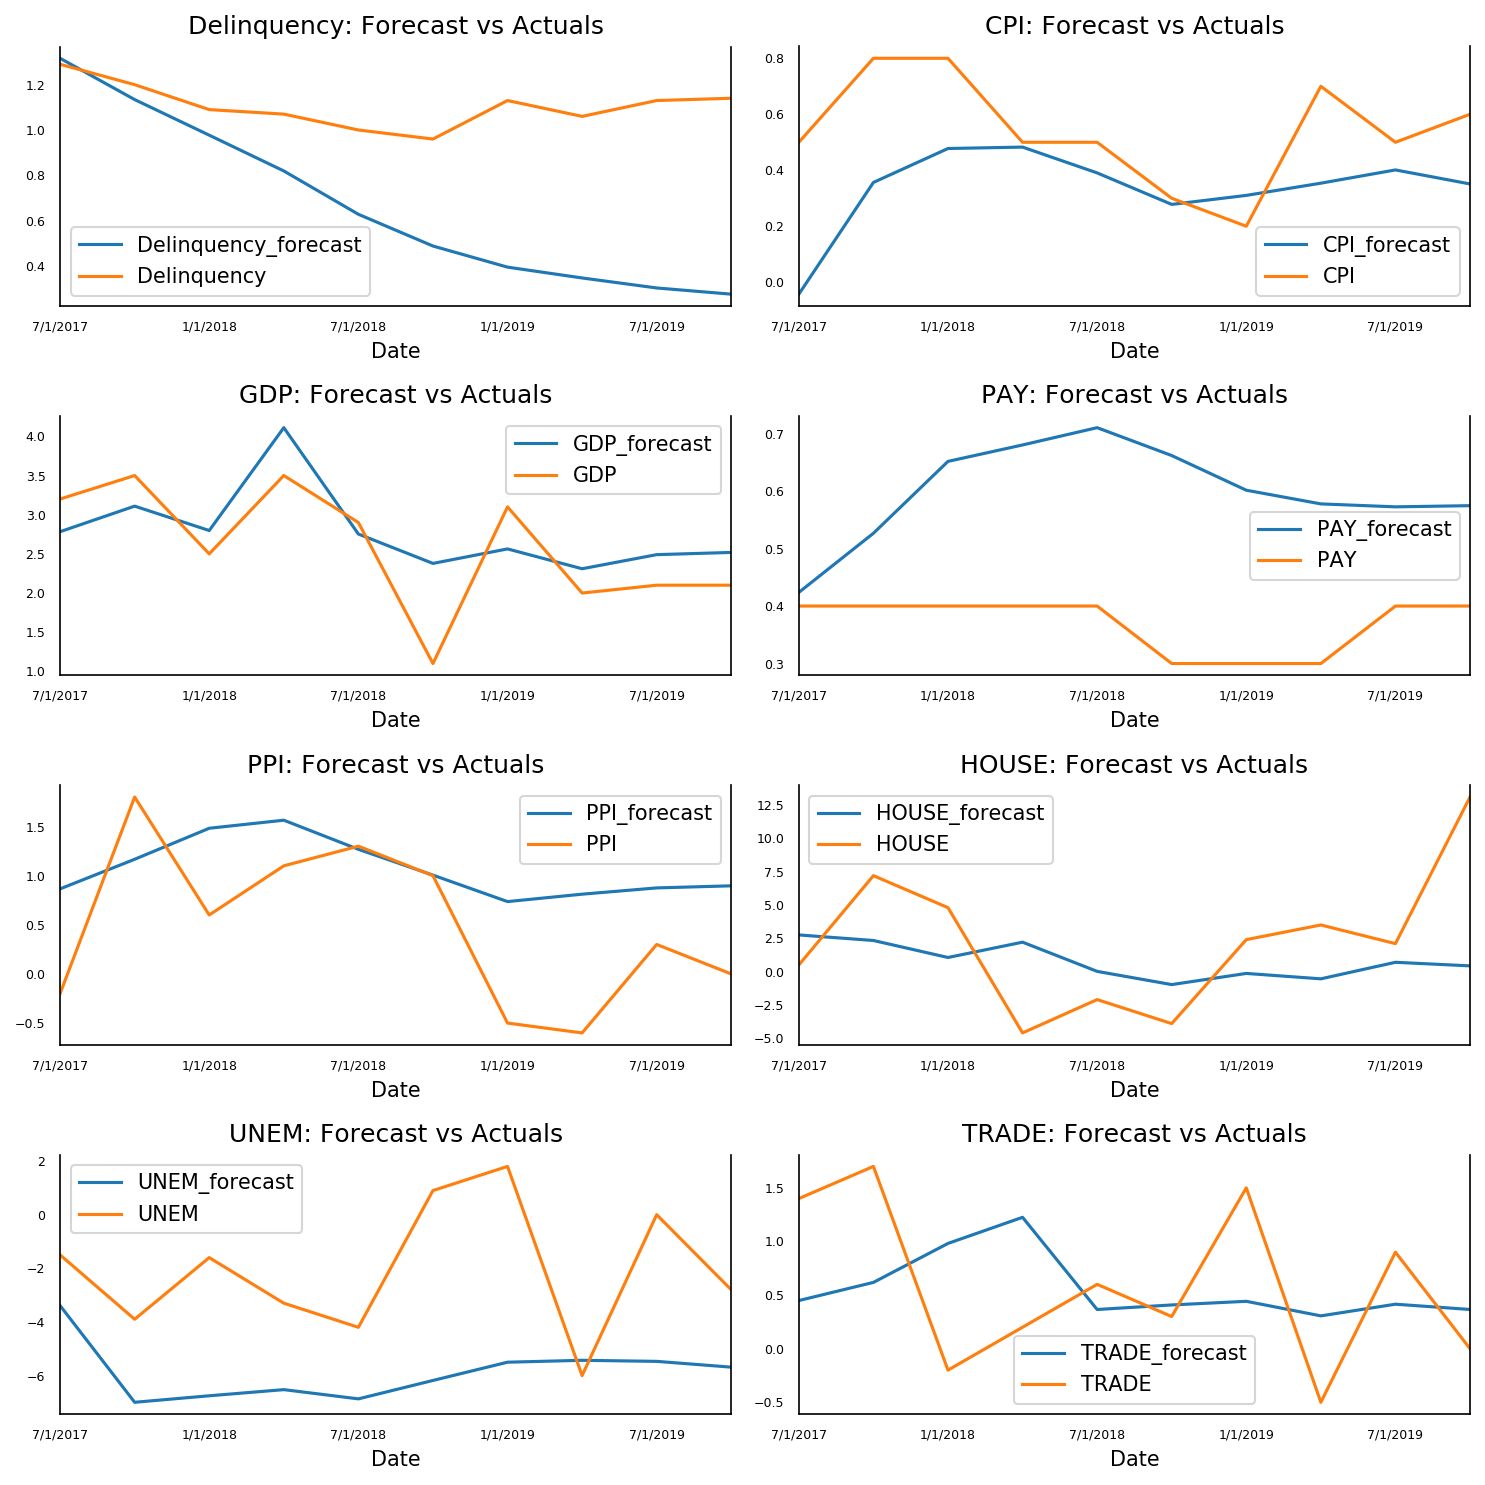

In [27]:
fig, axes = plt.subplots(nrows=int(len(dataset_train.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset_train.columns, axes.flatten())):
    dataset_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [28]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)

#Print Summary
print('Forecast Accuracy of: Delinquency')
accuracy_prod = forecast_accuracy(dataset_results['Delinquency_forecast'].values, dataset_test['Delinquency'])
for k, v in accuracy_prod.items():
    print(adjust(k), ':', round(v,4))

print('\nForecast Accuracy of: CPI')
accuracy_prod = forecast_accuracy(dataset_results['CPI_forecast'].values, dataset_test['CPI'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(dataset_results['GDP_forecast'].values, dataset_test['GDP'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: PAY')
accuracy_prod = forecast_accuracy(dataset_results['PAY_forecast'].values, dataset_test['PAY'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: PPI')
accuracy_prod = forecast_accuracy(dataset_results['PPI_forecast'].values, dataset_test['PPI'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: HOUSE')
accuracy_prod = forecast_accuracy(dataset_results['HOUSE_forecast'].values, dataset_test['HOUSE'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: UNEM')
accuracy_prod = forecast_accuracy(dataset_results['UNEM_forecast'].values, dataset_test['UNEM'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: TRADE')
accuracy_prod = forecast_accuracy(dataset_results['TRADE_forecast'].values, dataset_test['TRADE'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Delinquency
mape   : 0.4091
me     : -0.4387
mae    : 0.444
mpe    : -0.405
rmse   : 0.5406
corr   : 0.5305
minmax : 0.409

Forecast Accuracy of: CPI
mape   :  0.4027
me     :  -0.2041
mae    :  0.2261
mpe    :  -0.2925
rmse   :  0.2849
corr   :  0.2806
minmax :  0.3831

Forecast Accuracy of: GDP
mape   :  0.2461
me     :  0.1815
mae    :  0.4796
mpe    :  0.153
rmse   :  0.5617
corr   :  0.6936
minmax :  0.1715

Forecast Accuracy of: PAY
mape   :  0.6486
me     :  0.2281
mae    :  0.2281
mpe    :  0.6486
rmse   :  0.2478
corr   :  -0.1282
minmax :  0.3665

Forecast Accuracy of: PPI
mape   :  inf
me     :  0.5873
mae    :  0.7203
mpe    :  inf
rmse   :  0.8478
corr   :  0.6973
minmax :  0.7581

Forecast Accuracy of: HOUSE
mape   :  1.3045
me     :  -1.5145
mae    :  4.3359
mpe    :  -0.4034
rmse   :  5.3608
corr   :  0.06
minmax :  12.5329

Forecast Accuracy of: UNEM
mape   :  inf
me     :  -3.8202
mae    :  3.9341
mpe    :  -inf
rmse   :  4.464
corr   :  0.2321
m

C:\Users\Gandy Family\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
